In [3]:
import pandas as pd

In [4]:
fname = 'flickr_logos_dataset/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt'

In [5]:
# Read the text file into a pandas DataFrame
columns = ["imgname", "classname", "class", "xmin", "ymin", "xmax", "ymax"]
data_df = pd.read_csv(fname, sep=' ', header=None, names=columns,index_col=False)

In [6]:
data_df

,imgname,classname,class,xmin,ymin,xmax,ymax
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93
...,...,...,...,...,...,...,...
4526,2126991906.jpg,Yahoo,6,15,6,253,54
4527,217288720.jpg,Yahoo,6,136,161,304,222
4528,2472817996.jpg,Yahoo,6,2,4,499,106
4529,2514220918.jpg,Yahoo,6,1,69,342,157


In [7]:
data_df['class'].max()

6

In [8]:
data_df['classname'].unique()

array(['Adidas', 'Apple', 'BMW', 'Citroen', 'Cocacola', 'DHL', 'Fedex',
       'Ferrari', 'Ford', 'Google', 'Heineken', 'HP', 'Intel',
       'McDonalds', 'Mini', 'Nbc', 'Nike', 'Pepsi', 'Porsche', 'Puma',
       'RedBull', 'Sprite', 'Starbucks', 'Texaco', 'Unicef', 'Vodafone',
       'Yahoo'], dtype=object)

In [9]:
class_names = data_df['classname'].unique()        

In [10]:
class_names

array(['Adidas', 'Apple', 'BMW', 'Citroen', 'Cocacola', 'DHL', 'Fedex',
       'Ferrari', 'Ford', 'Google', 'Heineken', 'HP', 'Intel',
       'McDonalds', 'Mini', 'Nbc', 'Nike', 'Pepsi', 'Porsche', 'Puma',
       'RedBull', 'Sprite', 'Starbucks', 'Texaco', 'Unicef', 'Vodafone',
       'Yahoo'], dtype=object)

In [11]:
class_names[0]

'Adidas'

In [46]:
class_name_to_label = {class_name: label for label, class_name in enumerate(class_names)}

In [47]:
class_name_to_label

{'Adidas': 0,
 'Apple': 1,
 'BMW': 2,
 'Citroen': 3,
 'Cocacola': 4,
 'DHL': 5,
 'Fedex': 6,
 'Ferrari': 7,
 'Ford': 8,
 'Google': 9,
 'Heineken': 10,
 'HP': 11,
 'Intel': 12,
 'McDonalds': 13,
 'Mini': 14,
 'Nbc': 15,
 'Nike': 16,
 'Pepsi': 17,
 'Porsche': 18,
 'Puma': 19,
 'RedBull': 20,
 'Sprite': 21,
 'Starbucks': 22,
 'Texaco': 23,
 'Unicef': 24,
 'Vodafone': 25,
 'Yahoo': 26}

In [48]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

In [50]:
folder_path = "flickr_logos_dataset/flickr_logos_27_dataset_images"

In [51]:
data_df['full_path'] = folder_path + '/' + data_df['imgname']

In [54]:
data_df['full_path'][1]

'flickr_logos_dataset/flickr_logos_27_dataset_images/2451569770.jpg'

In [67]:
import config
from PIL import Image


In [81]:
def plot_img_bbox(idx):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    path = data_df.iloc[idx]['full_path']
    image = Image.open(path).convert("RGB")
    
    wt, ht = image.size
    image = image.resize((config.WIDTH, config.HEIGHT))
    
    xmin = data_df.iloc[idx][3]
    ymin = data_df.iloc[idx][4]
    xmax = data_df.iloc[idx][5]
    ymax = data_df.iloc[idx][6]
    
    xmin_corr = (xmin/wt)*config.WIDTH
    xmax_corr = (xmax/wt)*config.WIDTH
    ymin_corr = (ymin/ht)*config.HEIGHT
    ymax_corr = (ymax/ht)*config.HEIGHT
    
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    
    a.imshow(image)
    plt.axis('off')
    target = {}
    
    target['boxes'] = [[xmin_corr,ymin_corr,xmax_corr,ymax_corr]]
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

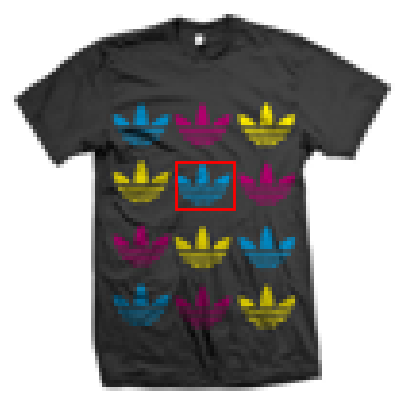

In [88]:
plot_img_bbox(20)

In [89]:
from model import FasterRCNNLightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from dataloader import Flickr27DataModule
from lightning.pytorch import seed_everything
import config

In [125]:


seed_everything(42, workers=True)


model = FasterRCNNLightning(num_classes=config.NUM_CLASSES,lr=config.LR)


checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename = config.CHECKPOINT_NAME,
    save_top_k = 1,
    verbose = True,
    monitor = 'mean_val',
    mode = 'min'
)

data_module = Flickr27DataModule(root_folder=config.MAIN_LOGO_FOLDER,
                                annotation_file=config.ANNOTATION_FILE_PATH,
                                batch_size=config.BATCH_SIZE,
                                val_split=config.VAL_SPLIT)

data_module.setup()

trainer = pl.Trainer(devices=-1, 
                  accelerator="gpu",
                  check_val_every_n_epoch=5,
                #   callbacks=[checkpoint_callback],
                  max_epochs=config.MAX_EPOCHS)




Seed set to 42
/home/sushovan/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sushovan/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [91]:
trainer.fit(model=model,datamodule=data_module)

/home/sushovan/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.4 M
-------------------------------------
41.2 M    Trainable params
222 K     Non-trainable params
41.4 M    Total params
165.709   Total estimated model params size (MB)


Epoch 0:   0%|          | 0/906 [00:00<?, ?it/s] 

/home/sushovan/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:83: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0:  14%|█▎        | 123/906 [03:40<23:26,  1.80s/it, loss=0.326, v_num=1, Loss_step=0.205]

/home/sushovan/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: Detected KeyboardInterrupt, attempting graceful shutdown...


In [92]:
import torchvision

In [93]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

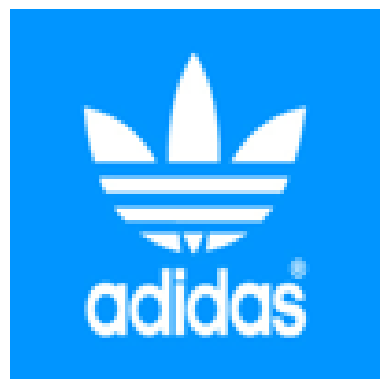

In [126]:
path = data_df.iloc[0]['full_path']
image = Image.open(path).convert("RGB")
wt, ht = image.size
image = image.resize((config.WIDTH, config.HEIGHT))

plt.imshow(image)
plt.axis('off')
plt.show()

In [127]:
import torch
import numpy as np

In [128]:
image = np.array(image).astype(np.float32)
image /= 255.0

In [129]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


In [130]:
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0)])

In [131]:
img = get_train_transform()(image=image)

In [132]:
image_tensor = img['image'].unsqueeze(0) 

In [133]:
model.eval()
with torch.no_grad():
    prediction = model.forward(image_tensor.to(model.device))[0]

In [145]:
def predplot_img_bbox(idx,iou_thresh=0.1):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    path = data_df.iloc[idx]['full_path']
    image = Image.open(path).convert("RGB")
    
    image = image.resize((config.WIDTH, config.HEIGHT))
    
    
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    
    a.imshow(image)
    plt.axis('off')
    
    img = np.array(image).astype(np.float32)
    img /= 255.0
    
    img = get_train_transform()(image=img)
    
    image_tensor = img['image'].unsqueeze(0) 
    
    model.eval()
    with torch.no_grad():
        prediction = model.forward(image_tensor.to(model.device))[0]
        
    prediction = apply_nms(prediction, iou_thresh=0.1)

            
    for box in (prediction['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

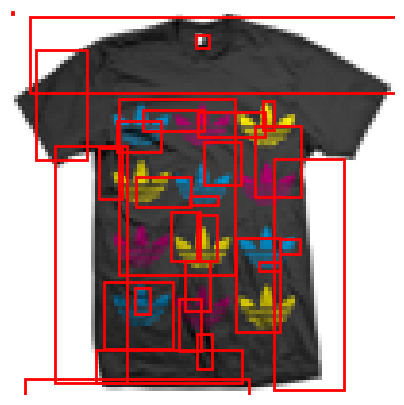

In [149]:
predplot_img_bbox(idx=20,iou_thresh=0.05)

In [150]:
from predict import predplot_img_bbox

/home/sushovan/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sushovan/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FileNotFoundError: [Errno 2] No such file or directory: '/checkpoints/BestFasterRCNN.ckpt'